# Explore annotations from Rana sierrae 2022 annotated dataset

imports

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'
from opensoundscape.annotations import BoxedAnnotations


/home/sml161/miniconda3/envs/opso_dev/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


plotting settings

In [2]:
from matplotlib import pyplot as plt

# create style sheet?
# plt.style.use('./styles/sam.mplstyle')

small_txt = 7
med_txt = 8
big_txt = 8
# set text sizes
plt.rcParams['font.size'] = small_txt
plt.rcParams['axes.labelsize'] = med_txt
plt.rcParams['axes.titlesize'] = big_txt
plt.rcParams['xtick.labelsize'] = small_txt
plt.rcParams['ytick.labelsize'] = small_txt
plt.rcParams['legend.fontsize'] = med_txt
plt.rcParams['figure.titlesize'] = big_txt
# opaque legend (<1 is not fully opaque)
plt.rcParams["legend.framealpha"] = 1.0
# set figure size
plt.rcParams['figure.figsize']=[6,2.5]
plt.rcParams['figure.dpi'] = 300
# set default font
# plt.rcParams['font.sans-serif'] = "Gill Sans"
# plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "gillsans"


# TIP use these 2 lines to list all available fonts:
# from matplotlib import font_manager
# font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# to add a font
# on linux, add .ttf font files to /usr/share/fonts/truetype/
# then follow these instructions https://scentellegher.github.io/visualization/2018/05/02/custom-fonts-matplotlib.html 

# tell matplotlib to create vector fonts 
# so you can edit them later! eg in Illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# plt.rcParams['lines.markersize'] = 1


#color and line style cycles #
# TIP: use https://coolers.co to create nice color palettes
#or modify this one https://coolors.co/35aad8-f3b61f-ba3b54-45b69c-8a96d7
from cycler import cycler
default_cycler = (cycler(color=['#35aad8','#f3b61f','#8a96d7','#45b69c','#ba3b54']) +
                  cycler(linestyle=['-', '--', '-.', ':','-']))
plt.rc('lines', linewidth=0.5)
plt.rc('axes', prop_cycle=default_cycler)

#use appropriate resolution for retina screens
%config InlineBackend.figure_format='retina'

# Load all annotation tables from Raven files

In [4]:
file_df=pd.read_csv('resources/audio_and_raven_files.csv')
data_dir='/media/emu/datasets/annotated/rana_sierrae_2022/'

In [35]:
np.unique(ba.df.annotation,return_counts=True)

(array(['D'], dtype=object), array([1]))

 # TODO: change this to just len(df[df.annotation==label]) to get # annotations per class in file_df

In [39]:
labels = ['A','B','C','D','E','X'] #see manuscript or other notebooks for description of each vocalization type

#loop through each pair of audio files and corresponding raven files 
for i in file_df.index:
    #full path to raven annotation .txt file
    raven_file = data_dir+file_df.at[i,'raven']
    
    # load the Raven annotations into OpenSoundscape with the BoxedAnnotations class
    ba = BoxedAnnotations.from_raven_file(raven_file,annotation_column='annotation')
    for label in labels:
        file_df.at[i, label]=len(ba.df[ba.df['annotation']==label])
#     # generate a table of 0/1 labels for each label class on 2 second audio segments
#     if len(ba.df)>0:
#         clip_df = ba.one_hot_clip_labels(
#             class_subset=labels,
#             full_duration=10,
#             clip_duration=2,
#             clip_overlap=0,
#             min_label_overlap=0.2,
#             min_label_fraction=0.5
#         ).astype(int)
    
#         for label in labels:
#             file_df.at[i, label]=clip_df[label].sum()
#     else:
#         for label in labels:
#             file_df.at[i, label]=0

### summary stats from annotated audio

Number of annotated 10-second clips:

In [42]:
len(file_df)

672

count of each annotation category:

In [44]:
file_df[file_df.columns[3:]].sum()

/tmp/ipykernel_1545669/457263948.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  file_df[file_df.columns[3:]].sum()


A    763.0
B     34.0
C    131.0
D    103.0
E    205.0
X    129.0
dtype: float64

Number of clips with 1+ annotation (exclude the 'X' class which is for unknown sounds)

In [45]:
call_types=['A','B','C','D','E']
(file_df[call_types].max(1)>0).sum()

434

Total number of Rana sierrae annotations: 

In [46]:
file_df[call_types].sum().sum()

1236.0

## Temporal patterns

first, add information about the date and time of each recording into our file_df table

In [22]:
from opensoundscape.audiomoth import audiomoth_start_time
import pytz
from datetime import datetime
import matplotlib

tz = pytz.timezone('US/Pacific')

# file_df['date']=[f.split('_')[4] for f in file_df.audio]
# file_df['time']=[f.split('_')[5] for f in file_df.audio]
strp_name = lambda f: '_'.join(Path(f).name.split('_')[2:4])+'.wav'
file_df['date']=[audiomoth_start_time(strp_name(f)).astimezone(tz).date() for f in file_df.audio]
file_df['time']=[audiomoth_start_time(strp_name(f)).astimezone(tz).time() for f in file_df.audio]
file_df['dt']=[audiomoth_start_time(strp_name(f)).astimezone(tz) for f in file_df.audio]


### Plot daily activity patterns for each call type

/tmp/ipykernel_1545669/3178842569.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dvar = file_df.groupby('time').sum()/7 / 17
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
too much 'glyf' table data: expected 42820, received 42914 bytes
too much 'hmtx' table data


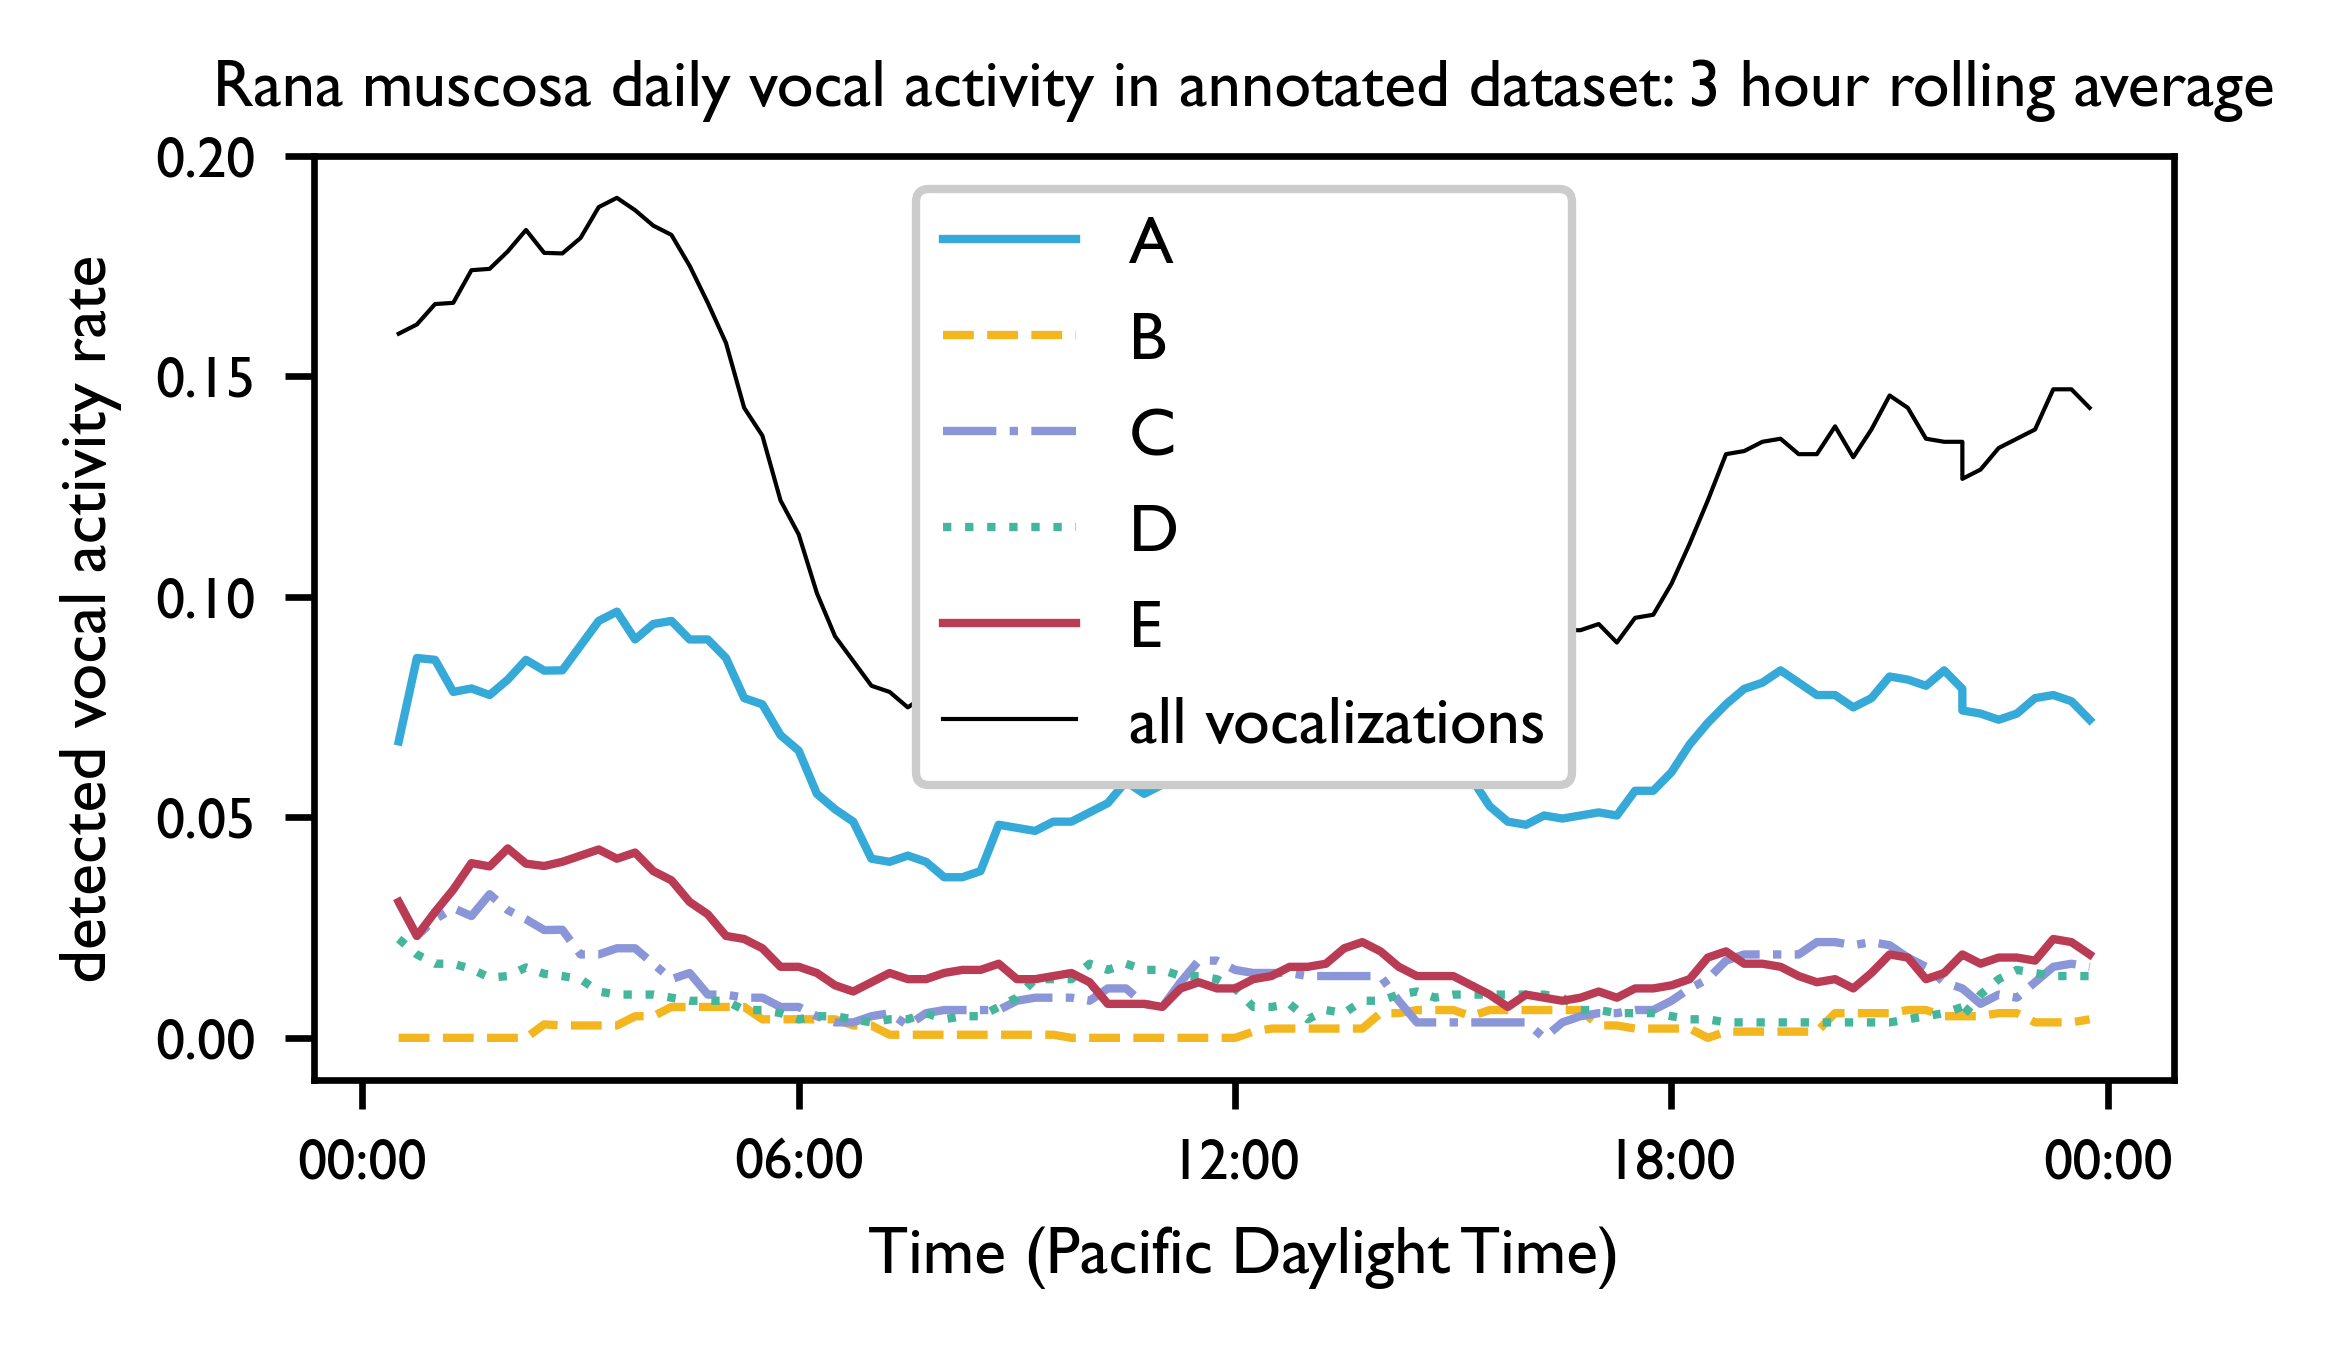

In [25]:
plt.figure(figsize=(4,2)) 

# Detected Vocal Activity Rate: fraction of clips per time period containing a vocalization
# divide # annotations by 17 because there are 17 2-second clips per 10 seconds; 
# and by 7 (one clip at each time of day for 7 consecutive days)
dvar = file_df.groupby('time').sum()/7 / 17

#plot a line for each call type: dvar vs time of day
x_axis = [datetime.combine(datetime.today(),t) for t in dvar.index]
for call_type in call_types: #leave out the "X" label, which is for unknowns
    # plt.scatter(x_axis,activity[call_type],label=call_type,alpha=0.3,linewidths=0,s=4)
    plt.plot(x_axis,dvar[call_type].rolling(12,min_periods=3).mean(),label=call_type,linewidth=1)

# plot a line for any call type
plt.plot(x_axis,dvar.sum(axis=1).rolling(12,min_periods=3).mean(),label='all vocalizations',c='black')

# PLOTTING SETTINGS
ax = plt.gca()
#reformat x ticks to time
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# use less axis labels
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend()
ax.set_xlabel('Time (Pacific Daylight Time)')
ax.set_ylabel('detected vocal activity rate')
# ax.set_ylim(0,0.025)

# plt.xticks(rotation=90)
plt.legend()
plt.title("Rana muscosa daily vocal activity in annotated dataset: 3 hour rolling average")

plt.savefig('./figures/daily_patterns_by_call_type_annotated.pdf')
plt.show()

# Inspect patterns across the seven days
### is the daily pattern consistent across the 7 annotated days?

Plot activity (annotations per 10 second clip) with individual days plotted separately, and an averaged line

here, dvar (detected vocal activity rate) is 3-hour rolling average of [number of vocalizations annotated per 10 second clip] with 1 10-second annotated clip every 15 minutes

/tmp/ipykernel_1545669/856952438.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dvar = file_df.groupby('time').sum()/7/17
/tmp/ipykernel_1545669/856952438.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  y=dfi.sum(axis=1).rolling(12,min_periods=3).mean()/17
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
too much 'glyf' table data: expected 42820, received 42914 bytes
too much 'hmtx' table data


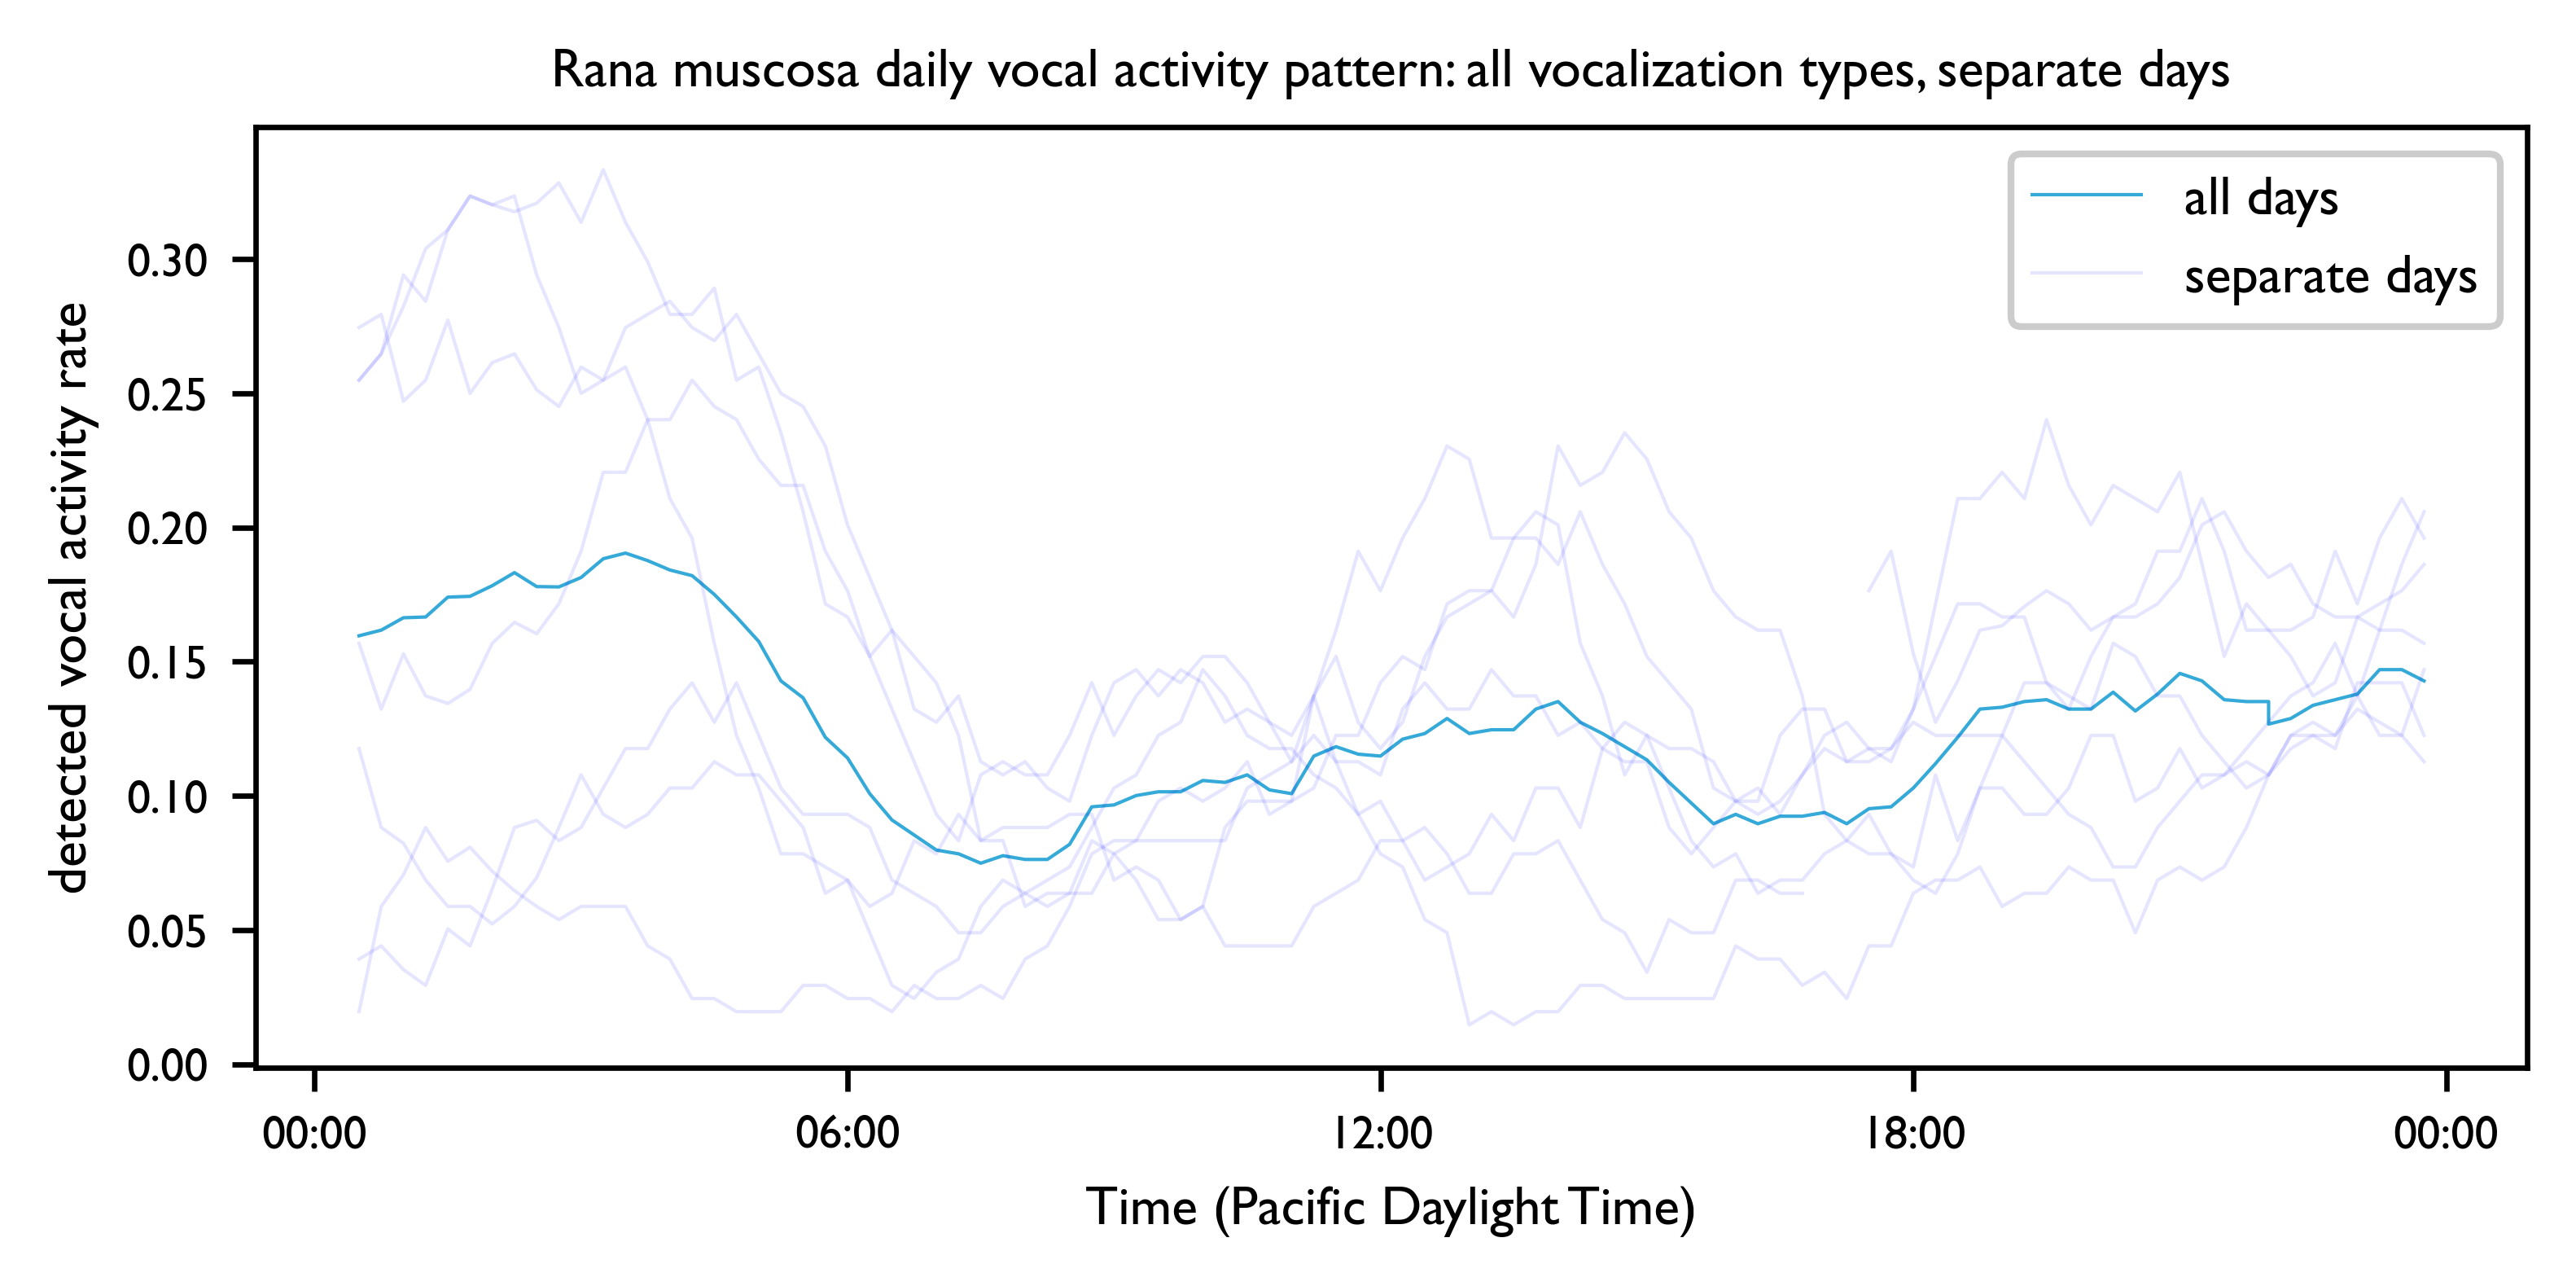

In [30]:
dvar = file_df.groupby('time').sum()/7/17

x_axis = [datetime.combine(datetime.today(),t) for t in dvar.index]

# plot the average of all days as a dark blue line
plt.plot(x_axis,dvar.sum(axis=1).rolling(12,min_periods=3).mean(),label='all days')

# plot each day as a separate light-blue line
for day in file_df.date.unique():
        dfi = file_df[file_df.date==day].sort_values(by='time')
        x_axis = [datetime.combine(datetime.today(),t) for t in dfi.time]
        y=dfi.sum(axis=1).rolling(12,min_periods=3).mean()/17
        plt.plot(x_axis,y,alpha=0.1,c='blue',linestyle='-')


# PLOTTING SETTINGS
ax = plt.gca()
#reformat x ticks to time
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# use less axis labels
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend({'all days':0,'separate days':1})
ax.set_xlabel('Time (Pacific Daylight Time)')
ax.set_ylabel('detected vocal activity rate')
plt.title("Rana muscosa daily vocal activity pattern: all vocalization types, separate days")
plt.savefig('./figures/daily_pattern_separate_days.pdf')
plt.show()

# Plot patterns across 7 days of annotated data

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
too much 'glyf' table data: expected 42820, received 42914 bytes
too much 'hmtx' table data


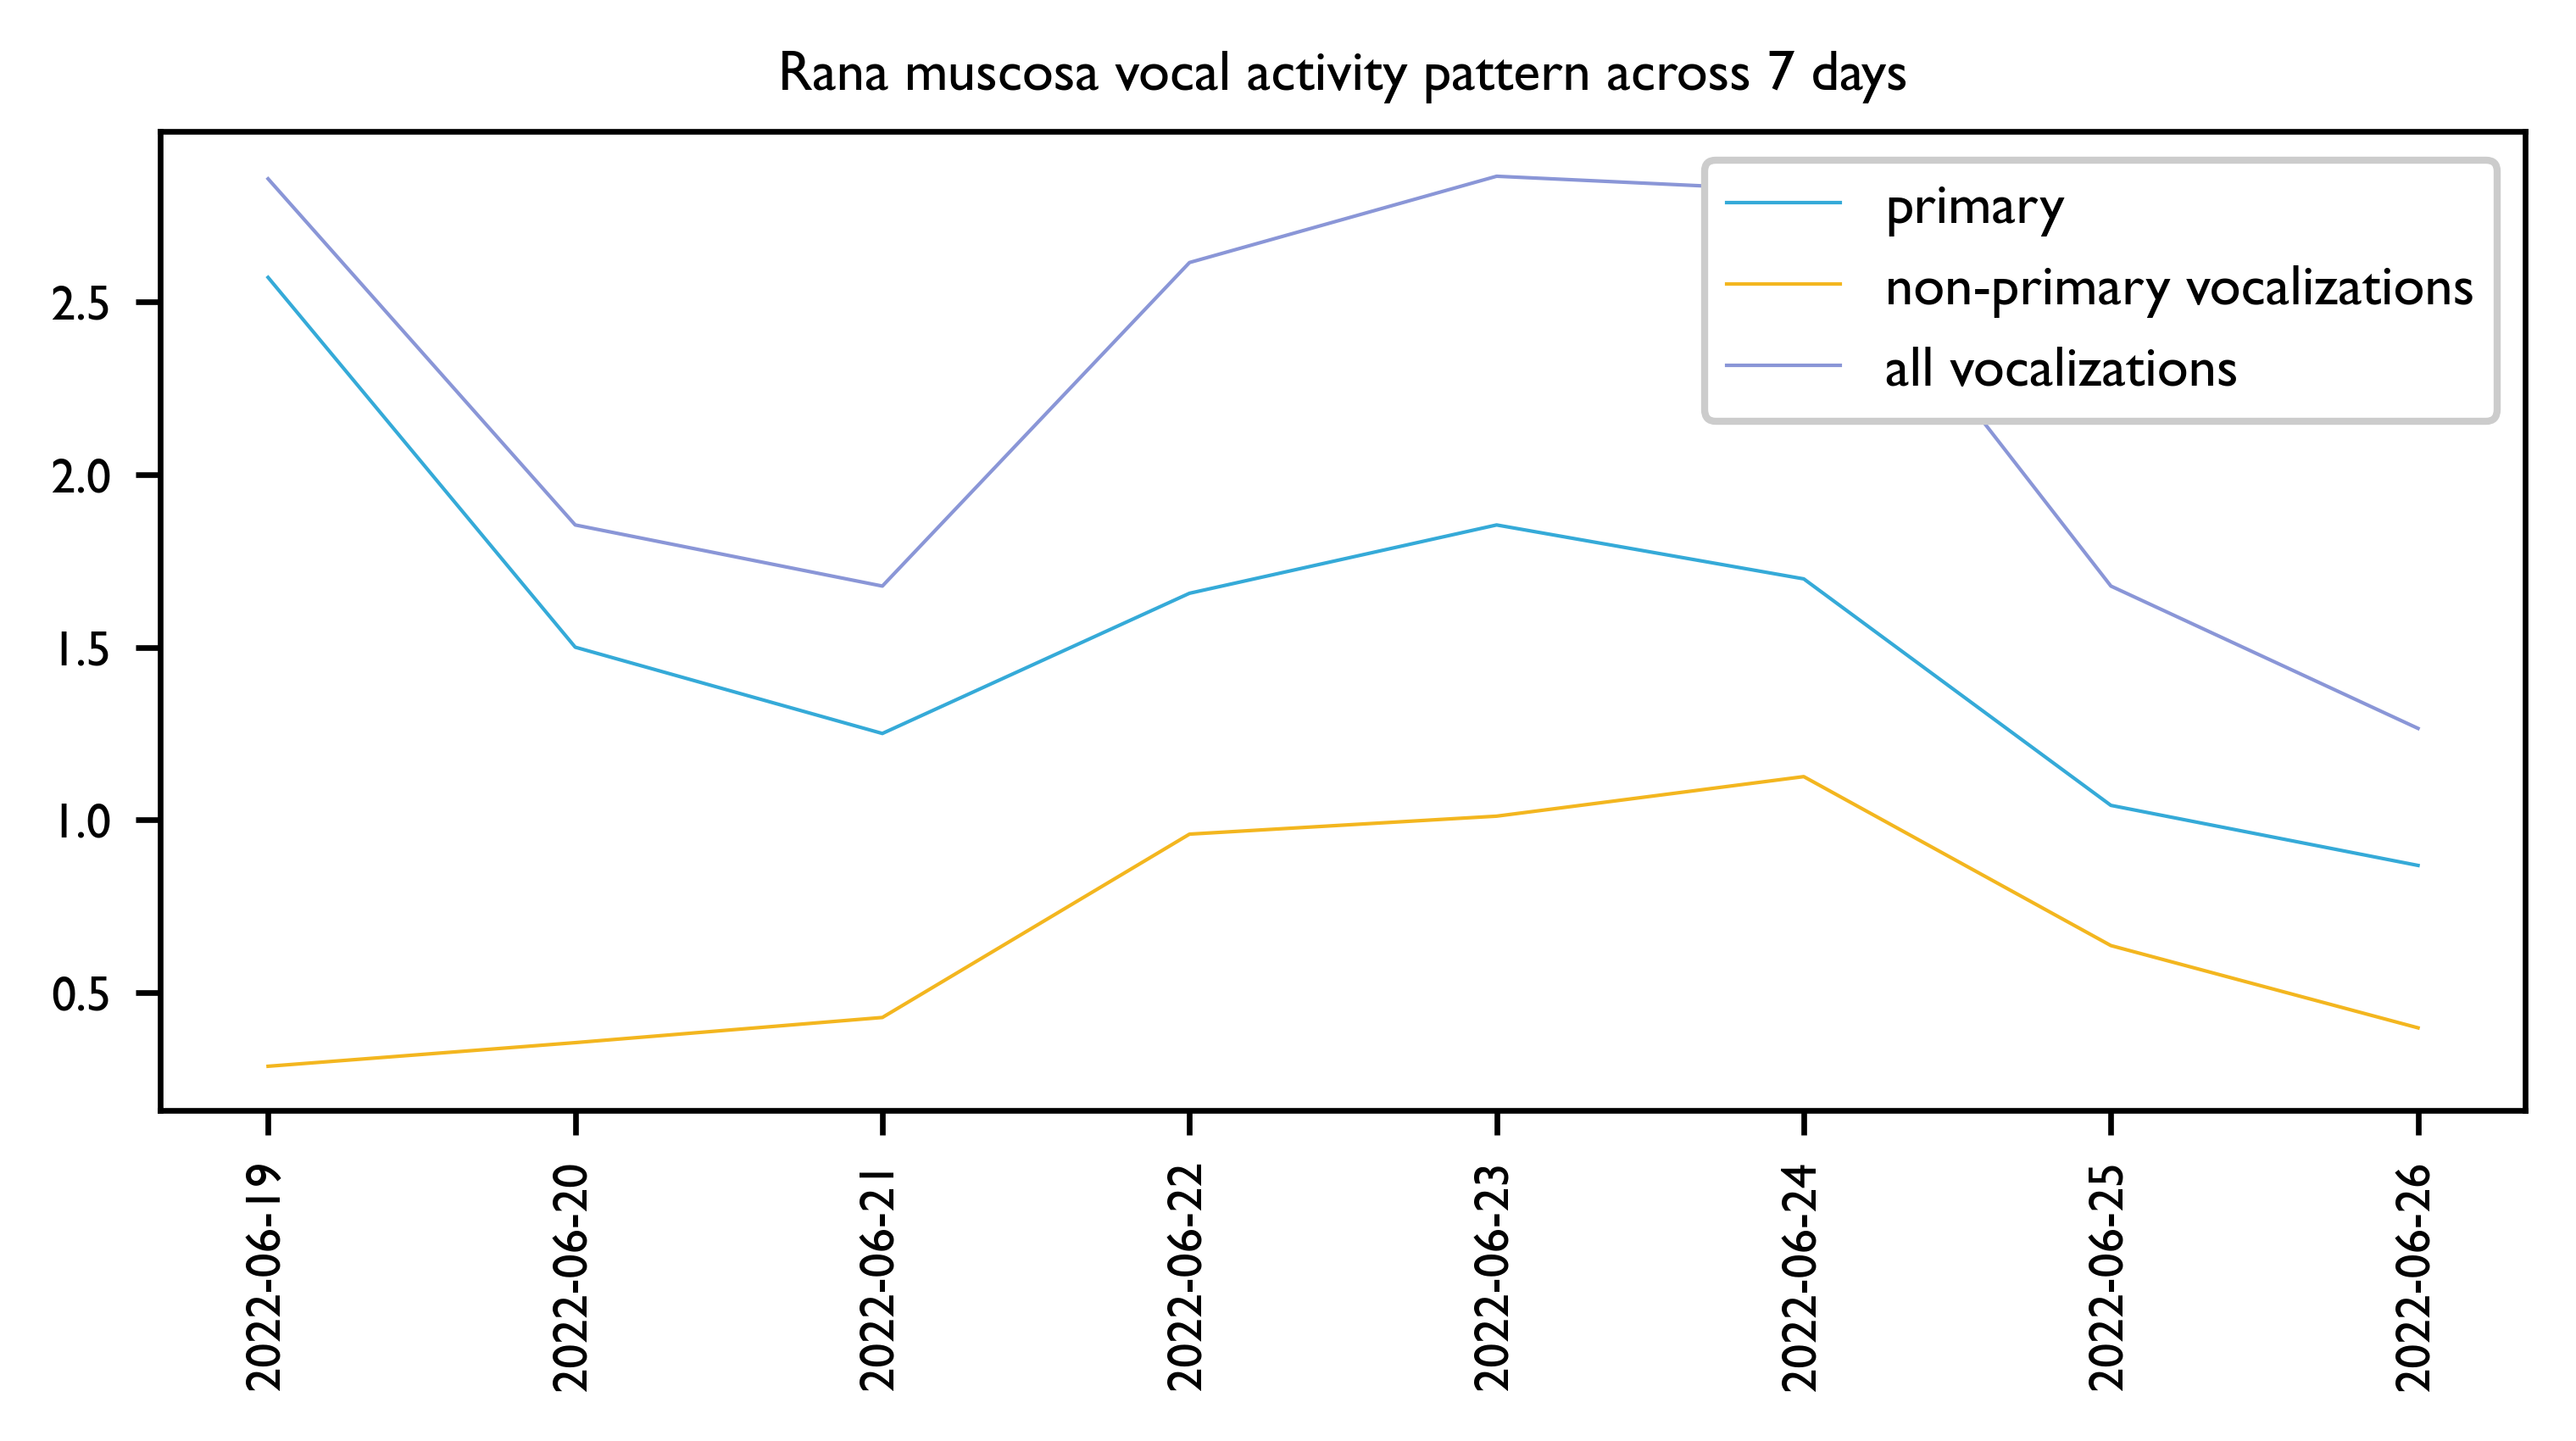

In [37]:
season = file_df.groupby('date').mean()
plt.plot(season.index,season.A+season.E,label='primary',linestyle='-')
plt.plot(season.index,season.sum(axis=1)-(season.A+season.E),label='non-primary vocalizations',linestyle='-')
plt.plot(season.index,season.sum(axis=1),label='all vocalizations',linestyle='-')

plt.xticks(rotation=90)
plt.legend()
plt.title("Rana muscosa vocal activity pattern across 7 days")
plt.savefig('./figures/vocal_activity_annotated_7_days.pdf')
plt.show()